# Text classification using Transformers.
This lab will still focus on text classification on the Imdb dataset.
In this lab session, we will focus on encoder-based transformer architecture, through the lens of the most famous model: **BERT**.

---

# Introduction

## HuggingFace

We have already experimented with some components provided by the HuggingFace library:
- the `datasets` library,
- the `tokenizer`.

Actually, HuggingFace library provides convenient API to deal with transformer models, like BERT, GPT, etc.  To quote their website: *Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce your compute costs, carbon footprint, and save you the time and resources required to train a model from scratch. Transformers support framework interoperability between PyTorch, TensorFlow, and JAX.*

## Goal of the lab session

We will experiment with the HuggingFace library. You'll have to load a model and to run it on your task.

Important things to keep in in minds are:
- Even if each model is a Transformer, they all have their peculiarities.
- What is the exact input format expected by the model?
- What is its exact output?
- Can you use the available model as is or should you make some modifications for your task?

These questions are actually part of the life of a NLP scientist. We will adress some of these questions in this lab and in the next lessons / labs / HW.

In [1]:
%%capture
%pip install transformers datasets

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm import tqdm

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
DEVICE = torch.device('mps')
DEVICE

device(type='mps')

## Download the training data

In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


## Prepare model inputs

The input format to BERT looks like it is  "over-specified", especially if you focus on just one type task: sequence classification, word tagging, paraphrase detection, ...  The format:
- Add special tokens to the start and end of each sentence.
- Pad & truncate all sentences to a single constant length.
- Explicitly differentiate real tokens from padding tokens with the "attention mask".

It looks like that:

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

If you don't want to recreate this kind of inputs with your own hands, you can use the pre-trained tokenizer associated to BERT. Moreover the function `encode_plus` will:
- Tokenize the sentence.
- Prepend the `[CLS]` token to the start.
- Append the `[SEP]` token to the end.
- Map tokens to their IDs.
- Pad or truncate the sentence to `max_length`
- Create attention masks for `[PAD]` tokens.


> 💡 *Note:* For computational reasons, we will use the [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) model, which is a 40% smaller than the original BERT model but still achieve about 95% of the performances of the original model.

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

Let's see how the tokenizer actually process the sequence:

In [5]:
# Some useful steps:
message = "hello my name is kevin"
tok = tokenizer.tokenize(message)
print("Tokens in the sequence:", tok)

Tokens in the sequence: ['hello', 'my', 'name', 'is', 'kevin']


🚧 **TODO** 🚧

Find an example of string where the tokens are not plain words.

In [6]:
# Find an example of string where the tokens are not plain words.
word = "don't"
tok = tokenizer.tokenize(word)
print("Tokens in the sequence:", tok)

Tokens in the sequence: ['don', "'", 't']


🚧 **TODO** 🚧

Tokens are mapped to vector embeddings. This is usually achieved with the `.encode` method of the tokenizer.

Use this method and display the ids associated to each tokens.

In [7]:
text = "my name is kevil"
tokenized_text = tokenizer.encode(text)
print(tokenized_text)

[101, 2026, 2171, 2003, 17710, 14762, 102]


🚧 **Question** 🚧

- How many ids are there? Is it the same than the number of tokens previously displayed?

- Why are there such special tokens?

**Answer**

TODO

🚧 **TODO** 🚧

Actually adding this can be controlled by using the keyword argument : `add_special_tokens`. Run the code below to make sure you can control this behavior.

In [8]:
text = "my name is kevin"
tokenized_text_without_special_tokens = tokenizer.encode(text, add_special_tokens=False)
assert tokenized_text_without_special_tokens[0] != 101

🚧 **TODO** 🚧

The `.encode` is the simplest one. Explore the difference betweem between `encode` and `encode_plus`.

- Make sure you understand each key / value pair.

> 💡 *Note:* The output of `tokenizer.encode_plus(text)` is the same as `tokenizer(text).`

In [9]:
text = "my name is kevin"
tokenized_text = tokenizer.encode_plus(text)
print(tokenized_text)

{'input_ids': [101, 2026, 2171, 2003, 4901, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


## Data pre-processing

Usual data-processing for torch. Same as previous lab.

In [10]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )
    x["labels"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [27]:
n_samples = 10000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)

# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["input_ids", "labels"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

🚧 **TODO** 🚧

Complete the following code.

In [28]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label". 
        input_ids = [x["input_ids"] for x in batch]
        labels = [x["labels"] for x in batch]

        padded = self.tokenizer.pad(
            {"input_ids": input_ids},
            return_tensors='pt',
            padding=True
        )

        features = {
            "input_ids": padded["input_ids"],
            "attention_mask": padded["attention_mask"],
            "labels": torch.tensor(labels, dtype=torch.long),
        }

        return features

In [29]:
data_collator = DataCollator(tokenizer)

In [30]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

# Building a model

We are going to build a basic transformer encoder, based on the Bert's architecture.

## Architecture configuration

In HuggingFace, model's parameters are specified through a `config` object.



🚧 **TODO** 🚧
For our first experiment, we want to build from a standard stack of transformer layers.

This is done through the `BertModel` class.

Each model is parametrized by a `config` object, that specifies its parameters.

Experiment with `BertConfig`.
Explore the effect of each hyperparameter on the total number of parameters.

In [31]:
from transformers import BertConfig
from transformers import BertModel

model_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=64,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=48,
    max_position_embeddings=256,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.2,
)
bert = BertModel(model_config)
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 64, padding_idx=0)
    (position_embeddings): Embedding(256, 64)
    (token_type_embeddings): Embedding(2, 64)
    (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-7): 8 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=64, out_features=64, bias=True)
            (key): Linear(in_features=64, out_features=64, bias=True)
            (value): Linear(in_features=64, out_features=64, bias=True)
            (dropout): Dropout(p=0.3, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=64, out_features=64, bias=True)
            (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
     

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, we printed out the names and dimensions of the weights for:

- The embedding layer
- The first of the twelve transformers
- The output layer.



In [32]:
# Get all of the model's parameters as a list of tuples.
params = list(bert.named_parameters())

In [33]:
print("The BERT model has {:} different named parameters.\n".format(len(params)))

print("==== Embedding Layer ====\n")

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer Layer ====\n")

for p in params[4:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 135 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                        (30522, 64)
embeddings.position_embeddings.weight                      (256, 64)
embeddings.token_type_embeddings.weight                      (2, 64)
embeddings.LayerNorm.weight                                    (64,)

==== First Transformer Layer ====

embeddings.LayerNorm.bias                                      (64,)
encoder.layer.0.attention.self.query.weight                 (64, 64)
encoder.layer.0.attention.self.query.bias                      (64,)
encoder.layer.0.attention.self.key.weight                   (64, 64)
encoder.layer.0.attention.self.key.bias                        (64,)
encoder.layer.0.attention.self.value.weight                 (64, 64)
encoder.layer.0.attention.self.value.bias                      (64,)
encoder.layer.0.attention.output.dense.weight               (64, 64)
encoder.layer.0.attention.output.dense.bias              

🚧 **TODO** 🚧

Test your bert.
We can already try the model on the validation set. Before just look at the output of the model on one batch.
- Interpret the output.  
- Do you understand everything ?


In [34]:
batch = next(iter(train_dataloader))

out = bert(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
)
print(out)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 1.3061e-02,  2.0823e+00, -1.2358e-01,  ..., -9.9366e-01,
          -5.1610e-01,  2.5967e+00],
         [ 8.1636e-02, -2.7847e-03,  8.8707e-01,  ...,  1.0999e-01,
          -2.2819e-01,  4.1294e-02],
         [ 7.7029e-01, -2.4948e-01, -9.5019e-02,  ...,  1.3892e-01,
           3.1369e-01,  1.3191e-01],
         ...,
         [-5.7655e-01, -5.7541e-02,  7.1151e-01,  ..., -1.0324e+00,
          -1.0687e+00,  2.2665e+00],
         [-7.7767e-01,  4.4473e-01, -4.8051e-02,  ..., -5.1423e-01,
           1.4958e+00,  2.8397e-01],
         [-1.5493e+00,  1.3680e+00,  1.7811e-01,  ...,  2.0885e-02,
          -1.6812e-01,  1.2928e+00]],

        [[-1.2360e+00,  1.6356e+00, -2.0344e-02,  ..., -1.0819e+00,
          -1.2531e+00,  2.9050e+00],
         [ 7.2335e-01, -3.0610e-01, -3.3780e-02,  ...,  1.6884e-01,
          -1.5065e-01,  2.4829e-02],
         [-1.4614e-03, -7.3683e-01,  8.4088e-01,  ..., -9.9970e-01,
           1.

## Building a classifier

Our `bert` model is simply a stack of transformer layers. We would like to use it as a backbone for text classification.

🚧 **Question** 🚧
Propose an architecture to perform text classification with a transformer.

**Answer**

TODO


🚧 **TODO** 🚧

Wraps the model into a classifier.

> 💡 *Hint*: Use the last hidden [CLS] vector representation to perform classification.

In [35]:
class BertClassifier(nn.Module):
    def __init__(self, bert):
        super(BertClassifier, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, **kwargs):
        output = self.bert(input_ids, attention_mask=attention_mask, **kwargs)
        pooled_output = output.pooler_output
        dropout_output = self.dropout(pooled_output)
        return self.classifier(dropout_output)

In [36]:
bert = BertModel(model_config)
model = BertClassifier(bert)
model.to(DEVICE)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 64, padding_idx=0)
      (position_embeddings): Embedding(256, 64)
      (token_type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-7): 8 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
    

🚧 **TODO** 🚧

Test your model on the batch.
Make sure it has the right shape.

In [37]:
out = model(
    input_ids=batch["input_ids"].to(DEVICE),
    attention_mask=batch["attention_mask"].to(DEVICE),
)
print(out.shape)

torch.Size([32, 2])


### Training

🚧 **TODO** 🚧

Train your model.
Make sure you track the following quantities per epoch:
- training loss
- training accuracy
- validation loss
- validation accuracy

In [38]:
def validation(model, valid_dataloader):
    model.eval()
    total_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return total_loss / n_valid, correct / total


n_valid = len(valid_set)
n_train = len(train_set)
print(n_valid, n_train)
validation(model, valid_dataloader)

2000 8000


(0.022082598567008973, 0.5065)

In [39]:
from prettytable import PrettyTable


def training(model, n_epochs, train_dataloader, valid_dataloader, lr=5e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1], dtype=torch.float32).to(DEVICE))
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        total = 0
        correct = 0

        progress_bar = tqdm(train_dataloader, desc="Epoch {:1d}".format(epoch), leave=True)
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(
                {
                    "loss": "{:.3f}".format(total_loss / (1 + len(progress_bar))),
                    "accuracy": "{:.3f}".format(correct / total),
                }
            )
        train_losses.append(total_loss / n_train)
        train_accs.append(correct / total)
        val_loss, val_acc = validation(model, valid_dataloader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        table = PrettyTable(["Epoch", "Train loss", "Train accuracy", "Validation loss", "Validation accuracy"])
        table.add_row([epoch, train_losses[-1], train_accs[-1], val_losses[-1], val_accs[-1]])
        print(table)
    return train_losses, train_accs, val_losses, val_accs

In [40]:
bert = BertModel(model_config)
model = BertClassifier(bert)
model.to(DEVICE)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 64, padding_idx=0)
      (position_embeddings): Embedding(256, 64)
      (token_type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-7): 8 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
    

In [41]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

In [42]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model, 10, train_dataloader, valid_dataloader
)

Epoch 0: 100%|██████████| 250/250 [01:01<00:00,  4.05it/s, loss=0.691, accuracy=0.507]


+-------+----------------------+----------------+---------------------+---------------------+
| Epoch |      Train loss      | Train accuracy |   Validation loss   | Validation accuracy |
+-------+----------------------+----------------+---------------------+---------------------+
|   0   | 0.021693132244050502 |    0.506625    | 0.02183334183692932 |        0.5035       |
+-------+----------------------+----------------+---------------------+---------------------+


Epoch 1: 100%|██████████| 250/250 [01:01<00:00,  4.04it/s, loss=0.689, accuracy=0.527]


+-------+----------------------+----------------+----------------------+---------------------+
| Epoch |      Train loss      | Train accuracy |   Validation loss    | Validation accuracy |
+-------+----------------------+----------------+----------------------+---------------------+
|   1   | 0.021605131171643734 |     0.527      | 0.021738541096448898 |        0.5505       |
+-------+----------------------+----------------+----------------------+---------------------+


Epoch 2: 100%|██████████| 250/250 [01:01<00:00,  4.04it/s, loss=0.615, accuracy=0.651]


+-------+--------------------+----------------+---------------------+---------------------+
| Epoch |     Train loss     | Train accuracy |   Validation loss   | Validation accuracy |
+-------+--------------------+----------------+---------------------+---------------------+
|   2   | 0.0192810618840158 |    0.65075     | 0.01476356191933155 |        0.7855       |
+-------+--------------------+----------------+---------------------+---------------------+


Epoch 3: 100%|██████████| 250/250 [01:00<00:00,  4.14it/s, loss=0.322, accuracy=0.870]


+-------+----------------------+----------------+----------------------+---------------------+
| Epoch |      Train loss      | Train accuracy |   Validation loss    | Validation accuracy |
+-------+----------------------+----------------+----------------------+---------------------+
|   3   | 0.010110357793979346 |    0.870375    | 0.012693781267851591 |        0.837        |
+-------+----------------------+----------------+----------------------+---------------------+


Epoch 4: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, loss=0.227, accuracy=0.917]


+-------+----------------------+----------------+----------------------+---------------------+
| Epoch |      Train loss      | Train accuracy |   Validation loss    | Validation accuracy |
+-------+----------------------+----------------+----------------------+---------------------+
|   4   | 0.007136334813199937 |     0.917      | 0.012686806477606297 |        0.847        |
+-------+----------------------+----------------+----------------------+---------------------+


Epoch 5: 100%|██████████| 250/250 [01:00<00:00,  4.14it/s, loss=0.178, accuracy=0.938]


+-------+-----------------------+----------------+--------------------+---------------------+
| Epoch |       Train loss      | Train accuracy |  Validation loss   | Validation accuracy |
+-------+-----------------------+----------------+--------------------+---------------------+
|   5   | 0.0055697398101910945 |    0.937625    | 0.0137975779697299 |        0.846        |
+-------+-----------------------+----------------+--------------------+---------------------+


Epoch 6: 100%|██████████| 250/250 [01:00<00:00,  4.14it/s, loss=0.153, accuracy=0.950]


+-------+----------------------+----------------+----------------------+---------------------+
| Epoch |      Train loss      | Train accuracy |   Validation loss    | Validation accuracy |
+-------+----------------------+----------------+----------------------+---------------------+
|   6   | 0.004810571556910872 |    0.94975     | 0.013553735192865133 |        0.845        |
+-------+----------------------+----------------+----------------------+---------------------+


Epoch 7: 100%|██████████| 250/250 [01:00<00:00,  4.14it/s, loss=0.124, accuracy=0.959]


+-------+----------------------+----------------+----------------------+---------------------+
| Epoch |      Train loss      | Train accuracy |   Validation loss    | Validation accuracy |
+-------+----------------------+----------------+----------------------+---------------------+
|   7   | 0.003875551827484742 |    0.95925     | 0.016245588183403017 |        0.8295       |
+-------+----------------------+----------------+----------------------+---------------------+


Epoch 8: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, loss=0.094, accuracy=0.972]


+-------+-----------------------+----------------+----------------------+---------------------+
| Epoch |       Train loss      | Train accuracy |   Validation loss    | Validation accuracy |
+-------+-----------------------+----------------+----------------------+---------------------+
|   8   | 0.0029527012791950255 |    0.972375    | 0.016731716096401214 |        0.836        |
+-------+-----------------------+----------------+----------------------+---------------------+


Epoch 9: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, loss=0.076, accuracy=0.980]


+-------+---------------------+----------------+----------------------+---------------------+
| Epoch |      Train loss     | Train accuracy |   Validation loss    | Validation accuracy |
+-------+---------------------+----------------+----------------------+---------------------+
|   9   | 0.00239284425531514 |    0.979875    | 0.019685692630708216 |        0.8245       |
+-------+---------------------+----------------+----------------------+---------------------+


🚧 **TODO** 🚧

Plot the different curves (loss, accuracy for training and validation sets).

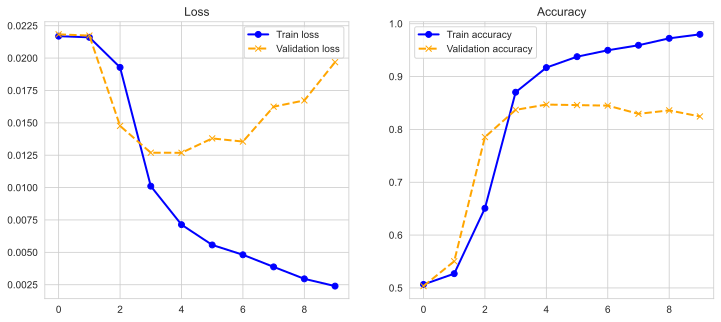

In [44]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[1].plot(list_train_acc, label="Train accuracy", color="blue", linestyle="-", marker="o", linewidth=2)
axs[1].plot(list_val_acc, label="Validation accuracy", color="orange", linestyle="--", marker="x", linewidth=2)
axs[0].plot(list_train_loss, label="Train loss", color="blue", linestyle="-", marker="o", linewidth=2)
axs[0].plot(list_val_loss, label="Validation loss", color="orange", linestyle="--", marker="x", linewidth=2)
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
axs[0].legend()
axs[1].legend()
plt.show()

🚧 **Question** 🚧

How does it compare with your convolution model from previous lab?
